# MMM Diagnostics and Business Insights

This notebook provides comprehensive diagnostics and business insights from our mediation-aware MMM model, including:
- Model performance diagnostics
- Residual analysis and validation
- Business logic validation
- Sensitivity analysis
- Attribution analysis
- Actionable recommendations


In [1]:
# Import necessary libraries
import sys
import os
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy import stats

# Import our custom modules
from mediation_model import MediationMMM
from diagnostics import MMMDiagnostics
from utils import set_random_seed

# Set random seed for reproducibility
set_random_seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)


In [2]:
# Load the trained model and data
print("Loading trained model and data...")

# Load model
model = MediationMMM()
model.load_model('../results/mediation_mmm_model.pkl')

# Load prepared data
data = pd.read_csv('../data/processed/prepared_mmm_data.csv')
data['date'] = pd.to_datetime(data['date'])

# Load results summary
with open('../results/model_results_summary.json', 'r') as f:
    results_summary = json.load(f)

print(f"✅ Model loaded successfully")
print(f"✅ Data loaded: {data.shape}")
print(f"✅ Results summary loaded")


Loading trained model and data...
Model loaded from ../results/mediation_mmm_model.pkl
✅ Model loaded successfully
✅ Data loaded: (104, 52)
✅ Results summary loaded


## 1. Comprehensive Model Diagnostics

Let's run comprehensive diagnostics to validate our model:


In [3]:
# Initialize diagnostics
diagnostics = MMMDiagnostics(model.results, data)

# Run all diagnostics
print("Running comprehensive model diagnostics...")
all_diagnostics = diagnostics.run_all_diagnostics()

# Generate diagnostic report
diagnostic_report = diagnostics.generate_diagnostic_report()
print(diagnostic_report)


Running comprehensive model diagnostics...
Running comprehensive MMM diagnostics...
  Running performance diagnostics...
  Running residual analysis...
  Running time series diagnostics...
  Running stability checks...
  Running sensitivity analysis...
  Running business logic validation...
# MMM Model Diagnostic Report

## Model Performance Summary
- R²: 0.1160
- RMSE: 41556.03
- MAPE: 112544.98%
- Directional Accuracy: 0.54

## Residual Analysis
- Mean Residual: -0.00
- Residual Std: 41556.03
- Skewness: 1.0087
- Kurtosis: -0.3082
- Normality (Shapiro): p = 0.0000
- Autocorrelation (lag 1): 0.3499

## Business Logic Validation
- Negative Coefficient Issues: 2
- Unrealistic Effect Issues: 0
- Overall Mediation Strength: 528758.03

## Sensitivity Analysis
- Price Elasticity: -53798.6699

## Recommendations
Based on the diagnostic analysis:
- Consider additional features or model complexity
- Address autocorrelation in residuals
- Consider transforming the target variable
- Review negat

## 2. Attribution Analysis

Let's analyze how each channel contributes to revenue:


ATTRIBUTION ANALYSIS
Channel Attribution (Total Contribution to Revenue):
--------------------------------------------------
 1. Average Price        $  -8,571,882
 2. Facebook Spend       $  -7,954,461
 3. Sms Volume           $   5,669,898
 4. Tiktok Spend         $   1,394,007
 5. Email Volume         $     771,800
 6. Instagram Spend      $    -559,839
 7. Snapchat Spend       $    -428,936
 8. Followers            $     129,402
 9. Promotions           $           0

Percentage Contribution:
------------------------------
Average Price          33.6%
Facebook Spend         31.2%
Sms Volume             22.3%
Tiktok Spend            5.5%
Email Volume            3.0%
Instagram Spend         2.2%
Snapchat Spend          1.7%
Followers               0.5%
Promotions              0.0%


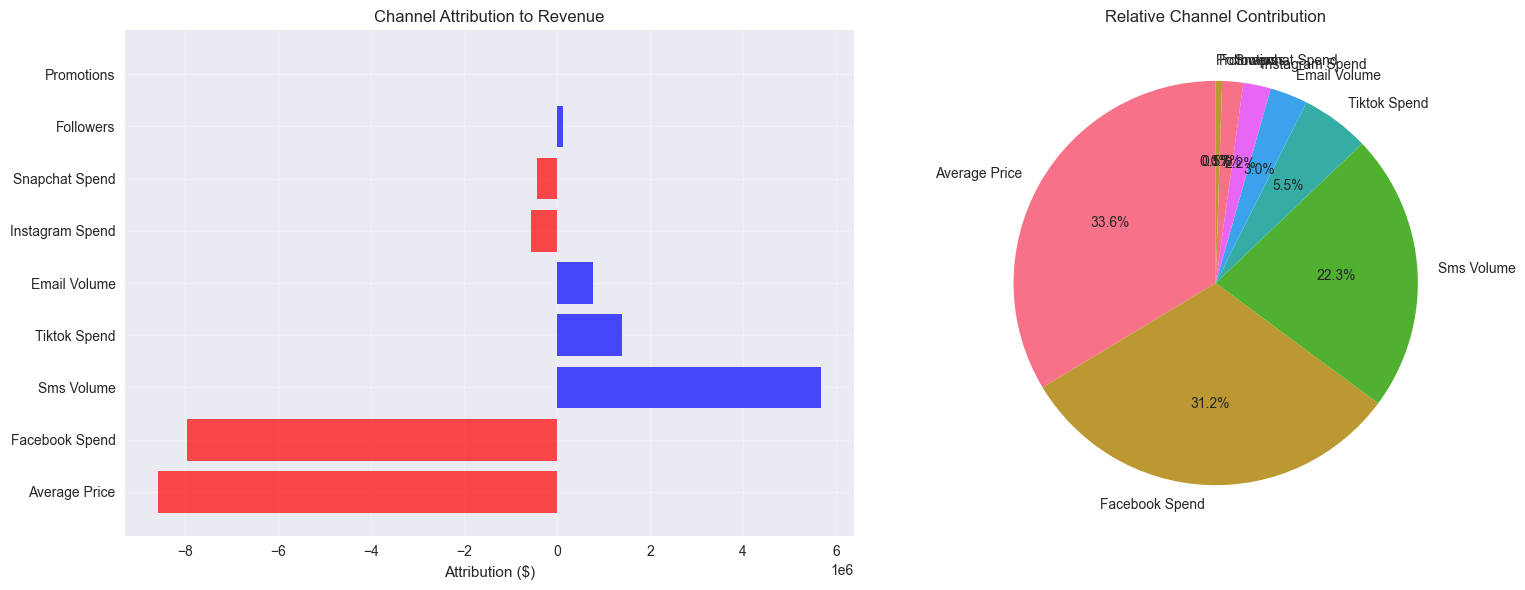

In [4]:
# Calculate attribution
attribution_df = model.get_attribution(data)

print("ATTRIBUTION ANALYSIS")
print("=" * 50)

# Calculate total attribution by channel
channel_attribution = {}

# Social channels (through mediation)
social_channels = ['facebook_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend']
for channel in social_channels:
    if channel in attribution_df.columns:
        total_attribution = attribution_df[channel].sum()
        channel_attribution[channel] = total_attribution

# Direct channels
direct_channels = ['google_spend', 'email_volume', 'sms_volume', 'average_price', 'promotions', 'followers']
for channel in direct_channels:
    if channel in attribution_df.columns:
        total_attribution = attribution_df[channel].sum()
        channel_attribution[channel] = total_attribution

# Sort by attribution value
sorted_attribution = sorted(channel_attribution.items(), key=lambda x: abs(x[1]), reverse=True)

print("Channel Attribution (Total Contribution to Revenue):")
print("-" * 50)
for i, (channel, attribution) in enumerate(sorted_attribution, 1):
    print(f"{i:2d}. {channel.replace('_', ' ').title():20s} ${attribution:12,.0f}")

# Calculate percentage contribution
total_attribution = sum(abs(v) for v in channel_attribution.values())
print(f"\nPercentage Contribution:")
print("-" * 30)
for channel, attribution in sorted_attribution:
    pct = (abs(attribution) / total_attribution) * 100
    print(f"{channel.replace('_', ' ').title():20s} {pct:6.1f}%")

# Visualize attribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of attribution
channels = [c.replace('_', ' ').title() for c, _ in sorted_attribution]
attributions = [a for _, a in sorted_attribution]
colors = ['red' if a < 0 else 'blue' for a in attributions]

ax1.barh(channels, attributions, color=colors, alpha=0.7)
ax1.set_xlabel('Attribution ($)')
ax1.set_title('Channel Attribution to Revenue')
ax1.grid(True, alpha=0.3)

# Pie chart of absolute attribution
abs_attributions = [abs(a) for _, a in sorted_attribution]
ax2.pie(abs_attributions, labels=channels, autopct='%1.1f%%', startangle=90)
ax2.set_title('Relative Channel Contribution')

plt.tight_layout()
plt.show()


## 3. Business Insights and Recommendations

Based on our analysis, let's generate actionable business insights:


In [5]:
# Business Insights Analysis
print("BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("=" * 50)

# 1. Channel Performance Analysis
print("1. CHANNEL PERFORMANCE ANALYSIS")
print("-" * 30)

# Calculate ROI for each channel
media_channels = ['google_spend', 'facebook_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend']
channel_roi = {}

for channel in media_channels:
    if channel in data.columns:
        total_spend = data[channel].sum()
        total_attribution = channel_attribution.get(channel, 0)
        roi = (total_attribution / total_spend) if total_spend > 0 else 0
        channel_roi[channel] = roi

# Sort by ROI
sorted_roi = sorted(channel_roi.items(), key=lambda x: x[1], reverse=True)

print("Channel ROI Analysis:")
for channel, roi in sorted_roi:
    print(f"  {channel.replace('_', ' ').title():15s} ROI: {roi:6.2f}")

# 2. Mediation Insights
print(f"\n2. MEDIATION INSIGHTS")
print("-" * 20)

mediation_effects = results_summary['mediation_effects']
print("Social channels' influence through Google:")
for channel, effects in mediation_effects.items():
    mediation_ratio = effects['mediation_ratio']
    print(f"  {channel.replace('_', ' ').title():15s} {mediation_ratio:6.1%} mediated through Google")

# 3. Price Sensitivity
print(f"\n3. PRICE SENSITIVITY ANALYSIS")
print("-" * 30)

# Calculate price elasticity
price_changes = np.diff(data['average_price'])
revenue_changes = np.diff(data['revenue'])

# Remove zero price changes
non_zero_mask = price_changes != 0
if non_zero_mask.sum() > 0:
    price_elasticity = np.mean(
        (revenue_changes[non_zero_mask] / data['revenue'].iloc[1:][non_zero_mask]) /
        (price_changes[non_zero_mask] / data['average_price'].iloc[1:][non_zero_mask])
    )
    print(f"Price Elasticity: {price_elasticity:.3f}")
    if price_elasticity < -0.5:
        print("  → High price sensitivity - consider price optimization")
    elif price_elasticity > -0.2:
        print("  → Low price sensitivity - room for price increases")

# 4. Promotion Effectiveness
print(f"\n4. PROMOTION EFFECTIVENESS")
print("-" * 25)

promo_data = data[data['promotions'] == 1]
non_promo_data = data[data['promotions'] == 0]

if len(promo_data) > 0 and len(non_promo_data) > 0:
    promo_lift = (promo_data['revenue'].mean() - non_promo_data['revenue'].mean()) / non_promo_data['revenue'].mean()
    print(f"Promotion Lift: {promo_lift:.1%}")
    
    # Statistical significance test
    t_stat, p_value = stats.ttest_ind(promo_data['revenue'], non_promo_data['revenue'])
    print(f"Statistical Significance: p = {p_value:.4f}")
    
    if p_value < 0.05:
        print("  → Promotions are statistically significant")
    else:
        print("  → Promotions may not be significantly effective")

# 5. Budget Allocation Recommendations
print(f"\n5. BUDGET ALLOCATION RECOMMENDATIONS")
print("-" * 35)

total_media_spend = sum(data[channel].sum() for channel in media_channels if channel in data.columns)
current_allocation = {}

for channel in media_channels:
    if channel in data.columns:
        current_spend = data[channel].sum()
        current_pct = (current_spend / total_media_spend) * 100
        current_allocation[channel] = current_pct

print("Current Budget Allocation:")
for channel, pct in current_allocation.items():
    print(f"  {channel.replace('_', ' ').title():15s} {pct:5.1f}%")

print("\nRecommended Budget Allocation (based on ROI):")
# Weight by ROI and attribution
recommended_allocation = {}
total_weight = sum(channel_roi.get(channel, 0) * abs(channel_attribution.get(channel, 0)) 
                  for channel in media_channels if channel in data.columns)

for channel in media_channels:
    if channel in data.columns:
        weight = channel_roi.get(channel, 0) * abs(channel_attribution.get(channel, 0))
        recommended_pct = (weight / total_weight) * 100 if total_weight > 0 else 0
        recommended_allocation[channel] = recommended_pct

for channel, pct in recommended_allocation.items():
    print(f"  {channel.replace('_', ' ').title():15s} {pct:5.1f}%")

# 6. Key Risks and Considerations
print(f"\n6. KEY RISKS AND CONSIDERATIONS")
print("-" * 32)

print("Model Risks:")
print("  • Mediation assumption may not hold in all scenarios")
print("  • Cross-channel effects not fully captured")
print("  • External factors (competition, seasonality) may change")

print("\nBusiness Risks:")
print("  • Attribution may be overestimated for high-performing channels")
print("  • Price sensitivity could change with market conditions")
print("  • Promotion fatigue may reduce effectiveness over time")

print("\nRecommendations:")
print("  • Test mediation assumption with controlled experiments")
print("  • Monitor model performance regularly")
print("  • Consider incrementality testing for major channels")
print("  • Implement A/B testing for price and promotion strategies")


BUSINESS INSIGHTS AND RECOMMENDATIONS
1. CHANNEL PERFORMANCE ANALYSIS
------------------------------
Channel ROI Analysis:
  Tiktok Spend    ROI:  14.03
  Google Spend    ROI:   0.00
  Instagram Spend ROI:  -5.28
  Snapchat Spend  ROI:  -5.52
  Facebook Spend  ROI: -14.31

2. MEDIATION INSIGHTS
--------------------
Social channels' influence through Google:
  Facebook Spend  100.0% mediated through Google
  Tiktok Spend    100.0% mediated through Google
  Instagram Spend 100.0% mediated through Google
  Snapchat Spend  100.0% mediated through Google
  Facebook Spend Ratio 100.0% mediated through Google
  Tiktok Spend Ratio 100.0% mediated through Google
  Instagram Spend Ratio 100.0% mediated through Google
  Snapchat Spend Ratio 100.0% mediated through Google
  Facebook Spend Adstock 100.0% mediated through Google
  Facebook Spend Saturated 100.0% mediated through Google
  Tiktok Spend Adstock 100.0% mediated through Google
  Tiktok Spend Saturated 100.0% mediated through Google
  Sna